In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import optuna

# Example time series: Airline passengers
from statsmodels.datasets import get_rdataset
data = get_rdataset("AirPassengers").data
series = data['value'].values

# Train-test split
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Optuna objective function
def objective(trial):
    p = trial.suggest_int('p', 1, 5)
    d = trial.suggest_int('d', 1, 2)
    q = trial.suggest_int('q', 1, 5)

    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        error = mean_squared_error(test, forecast)
        return error
    except error as e:
        print(e)
        return float('inf')

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best ARIMA parameters:", study.best_params)

# Fit best model and plot forecast
best_params = study.best_params
model = ARIMA(series, order=(best_params['p'], best_params['d'], best_params['q']))
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

from matplotlib import pyplot as plt
plt.plot(series, label='Original')
plt.plot(range(len(series), len(series) + 12), forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast with Optuna-Tuned Parameters')
plt.show()


In [6]:
ARIMA?

Init signature:
ARIMA(
    endog,
    exog=None,
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    trend=None,
    enforce_stationarity=True,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing='none',
    validate_specification=True,
)
Docstring:     
Autoregressive Integrated Moving Average (ARIMA) model, and extensions

This model is the basic interface for ARIMA-type models, including those
with exogenous regressors and those with seasonal components. The most
general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows
all specialized cases, including

- autoregressive models: AR(p)
- moving average models: MA(q)
- mixed autoregressive moving average models: ARMA(p, q)
- integration models: ARIMA(p, d, q)
- seasonal models: SARIMA(P, D, Q, s)
- regression with errors that follow one of the above ARIMA-type models

Parameters
----------
endog : array_like, optional
    The observed time-se

In [ ]:
# Step 0: Import libraries
import numpy as np

# Step 1: Make the series stationary (Differencing)
def difference(series, d):
    for _ in range(d):
        series = [series[i] - series[i - 1] for i in range(1, len(series))]
    return series

# Step 2: Fit AR(p) model (using past values)
def fit_ar(series, p):
    X = []
    y = []
    for i in range(p, len(series)):
        X.append(series[i - p:i])  # lag features
        y.append(series[i])
    X = np.array(X)
    y = np.array(y)
    # Solve linear regression: y = Xw + e
    phi = np.linalg.lstsq(X, y, rcond=None)[0]  # AR coefficients
    return phi

# Step 3: Calculate residuals
def compute_residuals(series, phi, p):
    residuals = []
    for i in range(p, len(series)):
        y_hat = np.dot(phi, series[i - p:i])
        residuals.append(series[i] - y_hat)
    return residuals

# Step 4: Fit MA(q) model to residuals
def fit_ma(residuals, q):
    X = []
    y = []
    for i in range(q, len(residuals)):
        X.append(residuals[i - q:i])
        y.append(residuals[i])
    X = np.array(X)
    y = np.array(y)
    theta = np.linalg.lstsq(X, y, rcond=None)[0]  # MA coefficients
    return theta

# Step 5: Forecast future value
def forecast(series, residuals, phi, theta, p, q):
    ar_part = np.dot(phi, series[-p:])
    ma_part = np.dot(theta, residuals[-q:])
    return ar_part + ma_part


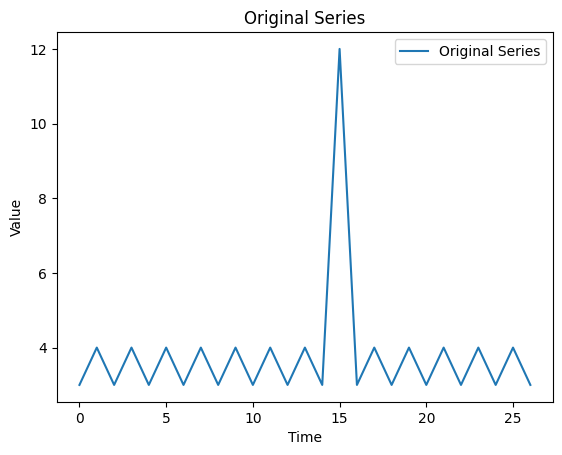

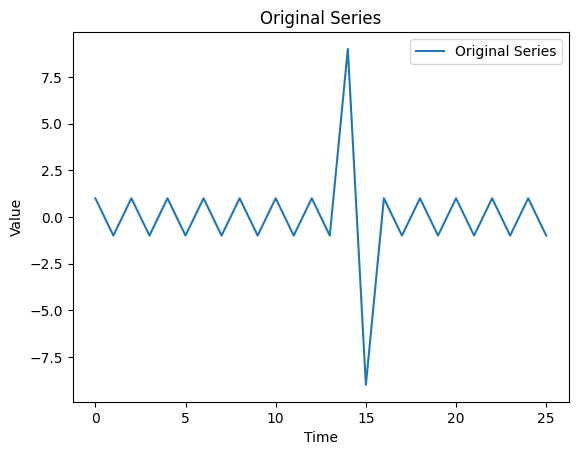

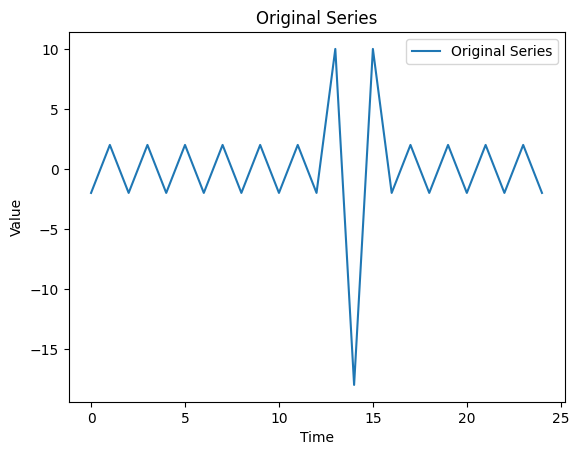

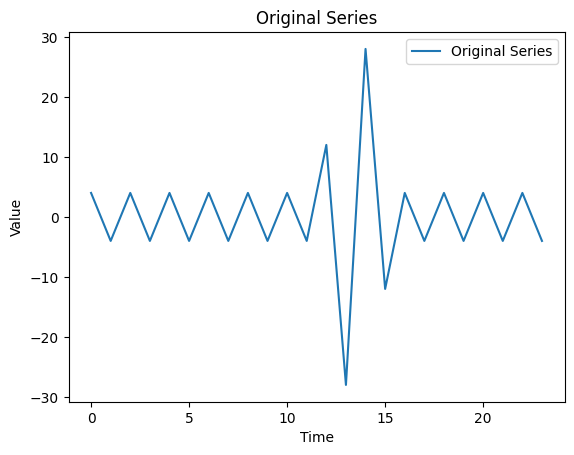

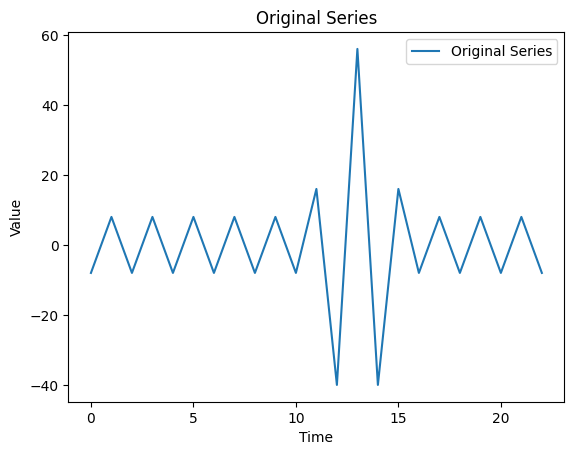

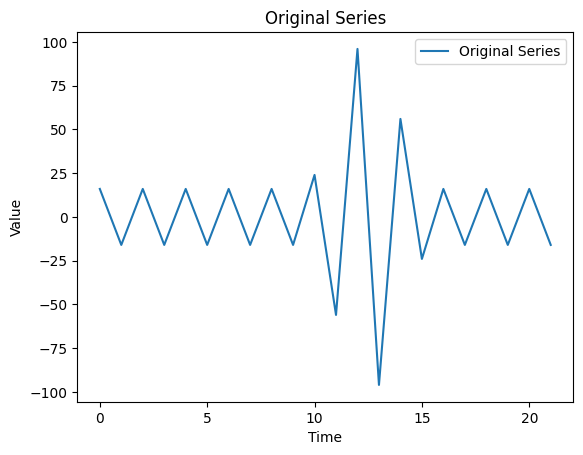

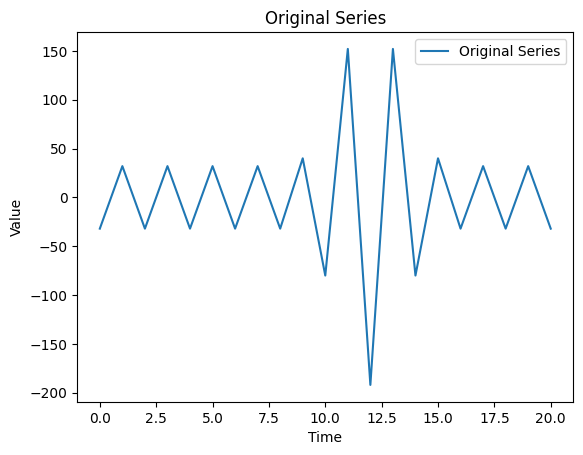

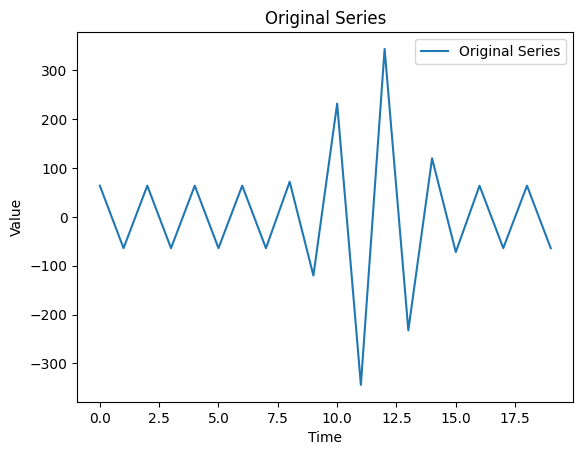

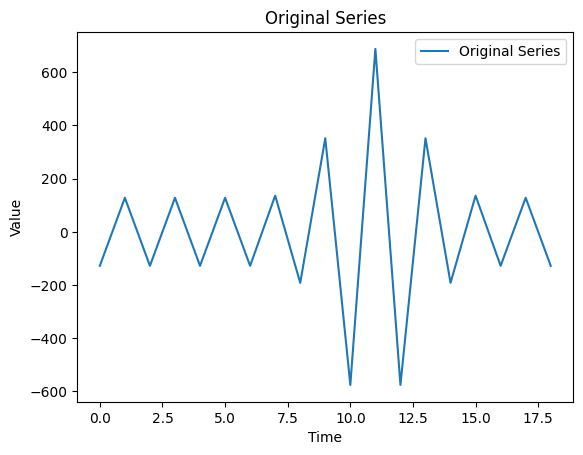

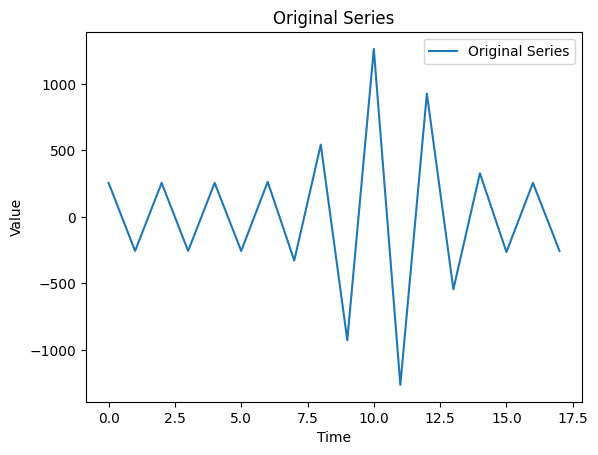

In [9]:
my_list = [3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 12, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, ]

from matplotlib import pyplot as plt


for _ in range(10):

    plt.plot(my_list, label='Original Series')
    plt.title('Original Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()  

    updated_list = []
    for index, element in enumerate(my_list):
        if index != 0:
            updated_element = element - my_list[index - 1]
            updated_list.append(updated_element)

    my_list = updated_list

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Sample time series
ts = [100, 102, 104, 107, 111, 115, 120]

# Parameters
p = 2  # AR order
d = 1  # differencing order
q = 1  # MA order

# Step 1: Differencing
def difference(series, d):
    diff_series = series.copy()
    for _ in range(d):
        diff_series = np.diff(diff_series)
    return diff_series

diff_ts = difference(ts, d)

# Step 2 & 3: Create lag features for AR and MA parts

def create_lagged_features(series, p, q):
    """
    Create lagged features for AR (lags of series) and MA (lags of residuals)
    """
    n = len(series)
    max_lag = max(p, q)
    
    # Prepare DataFrame to hold features
    df = pd.DataFrame()
    
    # AR features: lagged values of the differenced series
    for i in range(1, p+1):
        df[f'ar_lag_{i}'] = pd.Series(series).shift(i)
    
    # For MA, we don't have residuals yet; start with zeros for simplicity
    # We'll iteratively update residuals later
    # For now, create placeholders
    for i in range(1, q+1):
        df[f'ma_lag_{i}'] = 0.0
    
    df['target'] = series
    df = df.dropna().reset_index(drop=True)
    
    return df

df = create_lagged_features(diff_ts, p, q)

# Step 4: Fit initial AR model (ignore MA at first)
X_ar = df[[f'ar_lag_{i}' for i in range(1, p+1)]]
y = df['target']

model = LinearRegression()
model.fit(X_ar, y)

# Step 5: Calculate residuals from AR model
y_pred = model.predict(X_ar)
residuals = y - y_pred

# Step 6: Add MA lagged residuals to dataframe
for i in range(1, q+1):
    df[f'ma_lag_{i}'] = residuals.shift(i)
df = df.dropna().reset_index(drop=True)

# Step 7: Fit combined AR + MA model
X_ar_ma = df[[f'ar_lag_{i}' for i in range(1, p+1)] + [f'ma_lag_{i}' for i in range(1, q+1)]]
y_final = df['target']

model_final = LinearRegression()
model_final.fit(X_ar_ma, y_final)

# Step 8: Forecast next differenced value
last_ar_lags = diff_ts[-p:][::-1]  # reverse to match order
last_ma_lags = residuals[-q:][::-1]

x_new = np.concatenate([last_ar_lags, last_ma_lags]).reshape(1, -1)
next_diff_value = model_final.predict(x_new)[0]

# Step 9: Invert differencing to get next original scale value
next_value = ts[-1] + next_diff_value

print(f"Next forecasted value: {next_value:.2f}")
